In [7]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from IPython.display import display
from matplotlib import cm
%matplotlib notebook
from keras.models import Sequential
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Import dataset
df = pd.read_pickle('DoE_results_3d_1k.pkl')
points_df = df['points']

#Eliminate all NaN output values 
points_df_1 = points_df[(points_df['sigma_crit'] > 0) & (points_df['energy'] >= 0)]
sigma_crit_1 = points_df_1['sigma_crit']
energy_1 = points_df_1['energy']

#Find the quartiles to eliminate outliers
q1_s = np.percentile(sigma_crit_1,25.0)
q3_s = np.percentile(sigma_crit_1, 75.0)
q1_e = np.percentile(energy_1,25.0)
q3_e = np.percentile(energy_1, 75.0)

#Define the highest point which is not considered an outlier
high_s = q3_s + 1.5*(q3_s-q1_s)
high_e = q3_e + 1.5*(q3_e-q1_e)

#Eliminate outliers
points_df_2 = points_df[(points_df['sigma_crit'] < high_s) & (points_df['energy'] < high_e)]

#Convert the columns to arrays
RD = points_df_2[['ratio_d']].to_numpy()
RP = points_df_2[['ratio_pitch']].to_numpy()
RT = points_df_2[['ratio_top_diameter']].to_numpy()
S  = points_df_2[['sigma_crit']].to_numpy()
E  = points_df_2[['energy']].to_numpy()

input1 = RD
input2 = RP
input3 = RT
output = E


X_data = np.array([input1,input2, input3]).reshape(3,-1).T
Y_data = np.array([output]).reshape(-1,1)
xx1, xx2, xx3 = np.meshgrid(input1,input2, input3, sparse=True)
yy1 = output
train_size= 0.75
X_Train,X_Test,Y_Train,Y_Test=train_test_split(X_data, Y_data, train_size=train_size)

[[[0.004     ]
  [0.05575   ]
  [0.0341875 ]
  [0.0255625 ]
  [0.0428125 ]
  [0.01046875]
  [0.06221875]
  [0.03634375]
  [0.01478125]
  [0.04928125]
  [0.02340625]
  [0.04065625]
  [0.05898437]
  [0.03310937]
  [0.05035937]
  [0.02017187]
  [0.05467187]
  [0.07192187]
  [0.04604688]
  [0.03526562]
  [0.05251562]
  [0.06545312]
  [0.02232812]
  [0.05682812]
  [0.03957812]
  [0.00561719]
  [0.05736719]
  [0.03149219]
  [0.04874219]
  [0.01855469]
  [0.05305469]
  [0.02717969]
  [0.06167969]
  [0.04442969]
  [0.00992969]
  [0.01208594]
  [0.04658594]
  [0.03796094]
  [0.05521094]
  [0.01639844]
  [0.06814844]
  [0.03364844]
  [0.05952344]
  [0.04227344]
  [0.00669531]
  [0.05844531]
  [0.06707031]
  [0.04982031]
  [0.01963281]
  [0.03688281]
  [0.02825781]
  [0.04550781]
  [0.00885156]
  [0.06060156]
  [0.03472656]
  [0.06922656]
  [0.01316406]
  [0.04766406]
  [0.03903906]
  [0.00480859]
  [0.05655859]
  [0.02205859]
  [0.06518359]
  [0.04793359]
  [0.01774609]
  [0.05224609]
  [0.02637

In [2]:

def create_model (input_dimensions=3, neurons1=10, neurons2=10,neurons3=10,neurons4=10, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation))
    model.add(Dense(neurons2, activation=activation))
    model.add(Dense(neurons3, activation=activation))
    model.add(Dense(neurons4, activation=activation))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model


gridsearch = 0

if gridsearch==1:
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
    neurons1=[50,100]
    neurons2=[20,50]
    neurons3=[20,50]
    neurons4=[30,60]
    batch_size=[len(X_Train)]
    epochs=[1000]
    optimizer=['adam']
    
    param_grid = dict(batch_size=batch_size, epochs=epochs, neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, neurons4=neurons4, optimizer=optimizer )
    NN_model = KerasRegressor(build_fn=create_model, input_dimensions=np.shape(X_Train)[1])
    
    grid=GridSearchCV(estimator=NN_model, param_grid=param_grid, n_jobs=1, cv=3, iid= False )
    
    grid_result = grid.fit(X_Train, Y_Train, callbacks=[early_stopping], validation_data=(X_Test, Y_Test))
    
    history = grid_result.best_estimator_.fit(X_Train, Y_Train,callbacks=[early_stopping], validation_data=(X_Test, Y_Test))
    
    #print("Best: %f using %s1" % (grid_result.best_score, grid_result.best_params))
    
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
else:
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
    neurons1=50
    neurons2=50
    neurons3=50
    neurons4=50
   
    NN_model = KerasRegressor(build_fn=create_model, neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, neurons4=neurons4, batch_size=len(X_Train), epochs=1000, optimizer='adam', callbacks=[early_stopping],validation_data=(X_Test, Y_Test))
    history = NN_model.fit(X_Train, Y_Train)


Train on 376 samples, validate on 126 samples
Epoch 1/1000
376/376 [==============================] - 0s 346us/step - loss: 186.2435 - val_loss: 157.4072
Epoch 2/1000
376/376 [==============================] - 0s 27us/step - loss: 185.7793 - val_loss: 157.0109
Epoch 3/1000
376/376 [==============================] - 0s 11us/step - loss: 185.3572 - val_loss: 156.6618
Epoch 4/1000
376/376 [==============================] - 0s 11us/step - loss: 184.9879 - val_loss: 156.3243
Epoch 5/1000
376/376 [==============================] - 0s 11us/step - loss: 184.6315 - val_loss: 155.9838
Epoch 6/1000
376/376 [==============================] - 0s 19us/step - loss: 184.2714 - val_loss: 155.6197
Epoch 7/1000
376/376 [==============================] - 0s 11us/step - loss: 183.8804 - val_loss: 155.2361
Epoch 8/1000
376/376 [==============================] - 0s 8us/step - loss: 183.4666 - val_loss: 154.8284
Epoch 9/1000
376/376 [==============================] - 0s 11us/step - loss: 183.0283 - val_loss: 

Epoch 77/1000
376/376 [==============================] - 0s 11us/step - loss: 107.3829 - val_loss: 89.5087
Epoch 78/1000
376/376 [==============================] - 0s 11us/step - loss: 107.4322 - val_loss: 89.4800
Epoch 79/1000
376/376 [==============================] - 0s 16us/step - loss: 107.4734 - val_loss: 89.4633
Epoch 80/1000
376/376 [==============================] - 0s 13us/step - loss: 107.4976 - val_loss: 89.4529
Epoch 81/1000
376/376 [==============================] - 0s 16us/step - loss: 107.4983 - val_loss: 89.4464
Epoch 82/1000
376/376 [==============================] - 0s 16us/step - loss: 107.4741 - val_loss: 89.4388
Epoch 83/1000
376/376 [==============================] - 0s 11us/step - loss: 107.4267 - val_loss: 89.4314
Epoch 84/1000
376/376 [==============================] - 0s 11us/step - loss: 107.3587 - val_loss: 89.4280
Epoch 85/1000
376/376 [==============================] - 0s 8us/step - loss: 107.2749 - val_loss: 89.4308
Epoch 86/1000
376/376 [===============

Epoch 154/1000
376/376 [==============================] - 0s 11us/step - loss: 103.2575 - val_loss: 87.7360
Epoch 155/1000
376/376 [==============================] - 0s 11us/step - loss: 103.1734 - val_loss: 87.6527
Epoch 156/1000
376/376 [==============================] - 0s 29us/step - loss: 103.0877 - val_loss: 87.5661
Epoch 157/1000
376/376 [==============================] - 0s 13us/step - loss: 103.0003 - val_loss: 87.4772
Epoch 158/1000
376/376 [==============================] - 0s 21us/step - loss: 102.9109 - val_loss: 87.3864
Epoch 159/1000
376/376 [==============================] - 0s 16us/step - loss: 102.8198 - val_loss: 87.2940
Epoch 160/1000
376/376 [==============================] - 0s 11us/step - loss: 102.7267 - val_loss: 87.2010
Epoch 161/1000
376/376 [==============================] - 0s 8us/step - loss: 102.6314 - val_loss: 87.1079
Epoch 162/1000
376/376 [==============================] - 0s 19us/step - loss: 102.5341 - val_loss: 87.0148
Epoch 163/1000
376/376 [=====

Epoch 231/1000
376/376 [==============================] - 0s 27us/step - loss: 78.4422 - val_loss: 65.0782
Epoch 232/1000
376/376 [==============================] - 0s 13us/step - loss: 77.3976 - val_loss: 64.2131
Epoch 233/1000
376/376 [==============================] - 0s 19us/step - loss: 76.3355 - val_loss: 63.3606
Epoch 234/1000
376/376 [==============================] - 0s 11us/step - loss: 75.2307 - val_loss: 62.4333
Epoch 235/1000
376/376 [==============================] - 0s 24us/step - loss: 74.0892 - val_loss: 61.4313
Epoch 236/1000
376/376 [==============================] - 0s 11us/step - loss: 72.9045 - val_loss: 60.4225
Epoch 237/1000
376/376 [==============================] - 0s 27us/step - loss: 71.6769 - val_loss: 59.4089
Epoch 238/1000
376/376 [==============================] - 0s 16us/step - loss: 70.4016 - val_loss: 58.3028
Epoch 239/1000
376/376 [==============================] - 0s 24us/step - loss: 69.0735 - val_loss: 57.0945
Epoch 240/1000
376/376 [=============

Epoch 309/1000
376/376 [==============================] - 0s 16us/step - loss: 4.1111 - val_loss: 3.8849
Epoch 310/1000
376/376 [==============================] - 0s 11us/step - loss: 3.9791 - val_loss: 3.5137
Epoch 311/1000
376/376 [==============================] - 0s 13us/step - loss: 3.8468 - val_loss: 3.5644
Epoch 312/1000
376/376 [==============================] - 0s 21us/step - loss: 3.7197 - val_loss: 3.3677
Epoch 313/1000
376/376 [==============================] - 0s 16us/step - loss: 3.6018 - val_loss: 3.2803
Epoch 314/1000
376/376 [==============================] - 0s 21us/step - loss: 3.4932 - val_loss: 3.2448
Epoch 315/1000
376/376 [==============================] - 0s 29us/step - loss: 3.3930 - val_loss: 3.0458
Epoch 316/1000
376/376 [==============================] - 0s 11us/step - loss: 3.3004 - val_loss: 3.1328
Epoch 317/1000
376/376 [==============================] - 0s 13us/step - loss: 3.2135 - val_loss: 2.8506
Epoch 318/1000
376/376 [==============================]

Epoch 388/1000
376/376 [==============================] - 0s 13us/step - loss: 1.0648 - val_loss: 1.1088
Epoch 389/1000
376/376 [==============================] - 0s 16us/step - loss: 1.0579 - val_loss: 1.0753
Epoch 390/1000
376/376 [==============================] - 0s 21us/step - loss: 1.0525 - val_loss: 1.0988
Epoch 391/1000
376/376 [==============================] - 0s 16us/step - loss: 1.0428 - val_loss: 1.0660
Epoch 392/1000
376/376 [==============================] - 0s 19us/step - loss: 1.0311 - val_loss: 1.0588
Epoch 393/1000
376/376 [==============================] - 0s 11us/step - loss: 1.0226 - val_loss: 1.0708
Epoch 394/1000
376/376 [==============================] - 0s 27us/step - loss: 1.0168 - val_loss: 1.0372
Epoch 395/1000
376/376 [==============================] - 0s 11us/step - loss: 1.0093 - val_loss: 1.0497
Epoch 396/1000
376/376 [==============================] - 0s 11us/step - loss: 0.9992 - val_loss: 1.0320
Epoch 397/1000
376/376 [==============================]

Epoch 467/1000
376/376 [==============================] - 0s 16us/step - loss: 0.7027 - val_loss: 0.6681
Epoch 468/1000
376/376 [==============================] - 0s 13us/step - loss: 0.6581 - val_loss: 0.6746
Epoch 469/1000
376/376 [==============================] - 0s 27us/step - loss: 0.6237 - val_loss: 0.6546
Epoch 470/1000
376/376 [==============================] - 0s 11us/step - loss: 0.6130 - val_loss: 0.6450
Epoch 471/1000
376/376 [==============================] - 0s 24us/step - loss: 0.6238 - val_loss: 0.7074
Epoch 472/1000
376/376 [==============================] - 0s 8us/step - loss: 0.6433 - val_loss: 0.6634
Epoch 473/1000
376/376 [==============================] - 0s 16us/step - loss: 0.6581 - val_loss: 0.7243
Epoch 474/1000
376/376 [==============================] - 0s 11us/step - loss: 0.6553 - val_loss: 0.6510
Epoch 475/1000
376/376 [==============================] - 0s 24us/step - loss: 0.6409 - val_loss: 0.6747
Epoch 476/1000
376/376 [==============================] 

376/376 [==============================] - 0s 27us/step - loss: 0.4485 - val_loss: 0.4655
Epoch 546/1000
376/376 [==============================] - 0s 16us/step - loss: 0.4273 - val_loss: 0.4453
Epoch 547/1000
376/376 [==============================] - 0s 8us/step - loss: 0.4162 - val_loss: 0.4432
Epoch 548/1000
376/376 [==============================] - 0s 13us/step - loss: 0.4146 - val_loss: 0.4569
Epoch 549/1000
376/376 [==============================] - 0s 13us/step - loss: 0.4200 - val_loss: 0.4486
Epoch 550/1000
376/376 [==============================] - 0s 13us/step - loss: 0.4286 - val_loss: 0.4770
Epoch 551/1000
376/376 [==============================] - 0s 27us/step - loss: 0.4361 - val_loss: 0.4563
Epoch 552/1000
376/376 [==============================] - 0s 36us/step - loss: 0.4414 - val_loss: 0.4812
Epoch 553/1000
376/376 [==============================] - 0s 16us/step - loss: 0.4400 - val_loss: 0.4500
Epoch 554/1000
376/376 [==============================] - 0s 13us/step 

Epoch 624/1000
376/376 [==============================] - 0s 13us/step - loss: 0.3018 - val_loss: 0.3223
Epoch 625/1000
376/376 [==============================] - 0s 13us/step - loss: 0.3042 - val_loss: 0.3184
Epoch 626/1000
376/376 [==============================] - 0s 11us/step - loss: 0.3062 - val_loss: 0.3245
Epoch 627/1000
376/376 [==============================] - 0s 21us/step - loss: 0.3058 - val_loss: 0.3162
Epoch 628/1000
376/376 [==============================] - 0s 13us/step - loss: 0.3038 - val_loss: 0.3181
Epoch 629/1000
376/376 [==============================] - 0s 19us/step - loss: 0.3000 - val_loss: 0.3096
Epoch 630/1000
376/376 [==============================] - 0s 8us/step - loss: 0.2960 - val_loss: 0.3088
Epoch 631/1000
376/376 [==============================] - 0s 13us/step - loss: 0.2929 - val_loss: 0.3056
Epoch 632/1000
376/376 [==============================] - 0s 24us/step - loss: 0.2911 - val_loss: 0.3038
Epoch 633/1000
376/376 [==============================] 

376/376 [==============================] - 0s 13us/step - loss: 0.2422 - val_loss: 0.2506
Epoch 703/1000
376/376 [==============================] - 0s 24us/step - loss: 0.2389 - val_loss: 0.2456
Epoch 704/1000
376/376 [==============================] - 0s 13us/step - loss: 0.2361 - val_loss: 0.2447
Epoch 705/1000
376/376 [==============================] - 0s 21us/step - loss: 0.2337 - val_loss: 0.2419
Epoch 706/1000
376/376 [==============================] - 0s 11us/step - loss: 0.2318 - val_loss: 0.2411
Epoch 707/1000
376/376 [==============================] - 0s 16us/step - loss: 0.2305 - val_loss: 0.2404
Epoch 708/1000
376/376 [==============================] - 0s 16us/step - loss: 0.2297 - val_loss: 0.2398
Epoch 709/1000
376/376 [==============================] - 0s 27us/step - loss: 0.2293 - val_loss: 0.2401
Epoch 710/1000
376/376 [==============================] - 0s 13us/step - loss: 0.2292 - val_loss: 0.2392
Epoch 711/1000
376/376 [==============================] - 0s 21us/step

Epoch 781/1000
376/376 [==============================] - 0s 13us/step - loss: 0.2860 - val_loss: 0.3061
Epoch 782/1000
376/376 [==============================] - 0s 16us/step - loss: 0.2907 - val_loss: 0.2675
Epoch 783/1000
376/376 [==============================] - 0s 13us/step - loss: 0.2579 - val_loss: 0.2373
Epoch 784/1000
376/376 [==============================] - 0s 11us/step - loss: 0.2204 - val_loss: 0.2133
Epoch 785/1000
376/376 [==============================] - 0s 21us/step - loss: 0.1979 - val_loss: 0.2172
Epoch 786/1000
376/376 [==============================] - 0s 19us/step - loss: 0.2025 - val_loss: 0.2416
Epoch 787/1000
376/376 [==============================] - 0s 13us/step - loss: 0.2236 - val_loss: 0.2511
Epoch 788/1000
376/376 [==============================] - 0s 24us/step - loss: 0.2396 - val_loss: 0.2599
Epoch 789/1000
376/376 [==============================] - 0s 27us/step - loss: 0.2409 - val_loss: 0.2369
Epoch 790/1000
376/376 [==============================]

Epoch 860/1000
376/376 [==============================] - 0s 21us/step - loss: 0.2327 - val_loss: 0.2330
Epoch 861/1000
376/376 [==============================] - 0s 13us/step - loss: 0.2016 - val_loss: 0.2031
Epoch 862/1000
376/376 [==============================] - 0s 13us/step - loss: 0.1799 - val_loss: 0.1998
Epoch 863/1000
376/376 [==============================] - 0s 13us/step - loss: 0.1733 - val_loss: 0.2083
Epoch 864/1000
376/376 [==============================] - 0s 13us/step - loss: 0.1791 - val_loss: 0.2113
Epoch 865/1000
376/376 [==============================] - 0s 11us/step - loss: 0.1914 - val_loss: 0.2373
Epoch 866/1000
376/376 [==============================] - 0s 24us/step - loss: 0.2051 - val_loss: 0.2279
Epoch 867/1000
376/376 [==============================] - 0s 29us/step - loss: 0.2117 - val_loss: 0.2463
Epoch 868/1000
376/376 [==============================] - 0s 16us/step - loss: 0.2130 - val_loss: 0.2223
Epoch 869/1000
376/376 [==============================]

Epoch 938/1000
376/376 [==============================] - 0s 13us/step - loss: 0.1773 - val_loss: 0.2155
Epoch 939/1000
376/376 [==============================] - 0s 16us/step - loss: 0.1747 - val_loss: 0.2003
Epoch 940/1000
376/376 [==============================] - 0s 16us/step - loss: 0.1712 - val_loss: 0.2083
Epoch 941/1000
376/376 [==============================] - 0s 16us/step - loss: 0.1686 - val_loss: 0.1972
Epoch 942/1000
376/376 [==============================] - 0s 21us/step - loss: 0.1659 - val_loss: 0.2024
Epoch 943/1000
376/376 [==============================] - 0s 16us/step - loss: 0.1640 - val_loss: 0.1956
Epoch 944/1000
376/376 [==============================] - 0s 27us/step - loss: 0.1625 - val_loss: 0.1987
Epoch 945/1000
376/376 [==============================] - 0s 13us/step - loss: 0.1616 - val_loss: 0.1955
Epoch 946/1000
376/376 [==============================] - 0s 21us/step - loss: 0.1609 - val_loss: 0.1963
Epoch 947/1000
376/376 [==============================]

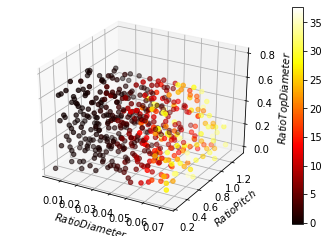

In [3]:
 %matplotlib inline
fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')

y_pred = history.model.predict(X_data)
y_data_pred = y_pred

yy1_data_pred = np.reshape(y_data_pred,np.shape(xx1))

ax3.set_xlabel('$Ratio Diameter$')
ax3.set_ylabel('$Ratio Pitch$')
ax3.set_zlabel('$Ratio Top Diameter$')

img = ax3.scatter(xx1,xx2,xx3,c=yy1_data_pred, cmap=plt.hot())
fig3.colorbar(img)
plt.show()

In [6]:
print(y_data_pred)
mse_value = mean_squared_error(output, y_data_pred)
r2_value  = r2_score(output, y_data_pred)
print('MSE', mse_value)
print('R2', r2_value)

[[ 1.68899119e-01]
 [ 1.46093721e+01]
 [ 1.95013475e+00]
 [ 6.12425268e-01]
 [ 4.33496284e+00]
 [-6.60238639e-02]
 [ 2.22354164e+01]
 [ 4.19218159e+00]
 [ 8.90489891e-02]
 [ 7.18339300e+00]
 [ 5.21523118e-01]
 [ 3.89926028e+00]
 [ 3.04401207e+01]
 [ 1.48360419e+00]
 [ 1.05553923e+01]
 [ 2.46664554e-01]
 [ 2.29138165e+01]
 [ 3.33878670e+01]
 [ 9.54435253e+00]
 [ 2.78207779e+00]
 [ 9.77581978e+00]
 [ 3.25020409e+01]
 [ 3.56204927e-01]
 [ 1.37200575e+01]
 [ 7.14751053e+00]
 [-1.73145741e-01]
 [ 2.03868065e+01]
 [ 1.30822611e+00]
 [ 8.23185539e+00]
 [ 2.71887720e-01]
 [ 1.67933273e+01]
 [ 1.13440359e+00]
 [ 1.70809517e+01]
 [ 8.39201355e+00]
 [-8.55913684e-02]
 [ 2.62870006e-02]
 [ 6.48424339e+00]
 [ 2.72580433e+00]
 [ 1.44388771e+01]
 [ 1.84999585e-01]
 [ 2.61419563e+01]
 [ 2.68117476e+00]
 [ 2.29073296e+01]
 [ 7.83013010e+00]
 [-7.33857602e-03]
 [ 1.59910336e+01]
 [ 2.99694138e+01]
 [ 1.00019236e+01]
 [ 2.93922067e-01]
 [ 2.92231870e+00]
 [ 7.17710972e-01]
 [ 8.05956936e+00]
 [ 2.0755179